In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

Using Theano backend.


In [2]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('capstone.db')
# tblGame , tblMovie, tblReview, tblTVShow
# load games dataset
games = pd.read_sql_query("SELECT * FROM tblGame;", conn)
games['gameID'] = games.index + 1
reviews = pd.read_sql_query("SELECT * FROM tblReview;", conn)

In [3]:
critic_reviews = reviews[reviews['reviewType'] == 'c']


In [4]:
import re

#longest review 188 words

def cleaning_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'\\r, u', ' ', sentence)
    sentence = re.sub(r'\\', "'", sentence)
    sentence = sentence.split()
    sentence = [re.sub("([^a-z0-9' \t])", '', x) for x in sentence]
    cleaned = [s for s in sentence if s != '']
    cleaned = ' '.join(cleaned)
    return cleaned

                        
critic_reviews['textClean'] = critic_reviews.apply(lambda row: cleaning_text(row['text'].encode("utf8")), axis=1)

/Users/Daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


477672
75.0
19.3140135003
106045
96010


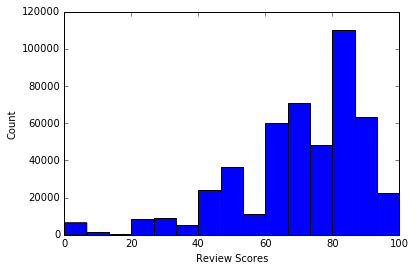

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt

print len(critic_reviews)
print critic_reviews['score'].median()
print critic_reviews['score'].std()
plt.hist(critic_reviews['score'], bins = 15)
plt.xlabel('Review Scores')
plt.ylabel('Count')
print len(critic_reviews[critic_reviews['score'] >= (85)])
print len(critic_reviews[critic_reviews['score'] <= (55)])

In [6]:
#label reviews 85 or over as positive and 55 or lower as negative

def binarizer(x):
    if x <= 55:
        return 0
    if x >= 85:
        return 1
    
critic_reviews['overall'] = critic_reviews['score'].apply(lambda row: binarizer(row))

/Users/Daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [116]:
import numpy as np

#drop rows with NA values for overall (scores between 55 and 85)
subset = critic_reviews[pd.notnull(critic_reviews['overall'])].reset_index()

length_df = subset
length_df['length'] = pd.DataFrame(subset['textClean'].apply(lambda x: len(x.split(' '))))
over = length_df[length_df['length'] > 2]
#print over.sort_values('length')
print len(over)

subset = over.drop(['author', 'text', 'score', 'date', 'thumbsUp', 'thumbsDown', 'reviewType'], axis = 1).reset_index()
print subset.head()
subset['overall'].value_counts()

195823
   level_0  index  gameID  movieID  tvShowID           publication  \
0        0      4     1.0      NaN       NaN  Digitally Downloaded   
1        1      5     2.0      NaN       NaN         God is a Geek   
2        2     31     2.0      NaN       NaN          PSX-Sense.nl   
3        3     32     2.0      NaN       NaN           Push Square   
4        4     33     2.0      NaN       NaN   We Got This Covered   

                                           textClean  overall  length  
0  it may sound like im being harsh on ginger but...      0.0      69  
1  jojos bizarre adventure eyes in heaven feature...      1.0      21  
2  the amount of fan service is both admirable an...      0.0      44  
3  fun for a few bouts now and then this is a bra...      0.0      37  
4  fans of the source material will find plenty o...      0.0      43  


1.0    105656
0.0     90167
Name: overall, dtype: int64

In [117]:
from collections import Counter
#results = set()
results = Counter()
subset['textClean'].str.lower().str.split().apply(results.update)

#number of unique words, just over 100,000
print len(results)

100038


In [118]:
max_features = 100038
# cut texts after this number of words 
max_length = 188
batch_size = 32

In [119]:
from keras.preprocessing import text
import keras 

tk = text.Tokenizer(max_features, filters=keras.preprocessing.text.base_filter(), split=" ")
tk.fit_on_texts(subset['textClean'])

#create data set, both features and labels
x = tk.texts_to_sequences(subset['textClean'])
y = subset['overall']

In [120]:
x = sequence.pad_sequences(x, maxlen = max_length, padding = 'post')

In [217]:
subset['textClean'][788]

"it's a rehash of what made sonic awesome in 1991 it's not a videogame from 2013 it controls like a game from 1991 it has gameplay like a game from 1991 warts blemishes sluggishness and all it is by all measures an astoundingly average game"

In [122]:
x[1]

array([30743,  1669,   151,  1063,     8,  2550,   233,    49,   164,
           3,     2,  1104,    62,   326,   134,   183,    23,     5,
          80,  4333,    64,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [123]:
#Divide dataset into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
x, y, test_size=0.2, random_state=42)

In [198]:
print len(X_train), len(X_test), len(y_train), len(y_test)
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

#Training data shape: 121233, 203
#Test data shape: 80822, 203


156658 39165 156658 39165
(156658, 188)
(156658,)
(39165, 188)
(39165,)


In [220]:
subset[['textClean', 'overall']][2000:2010]

,textClean,overall
2000,to the game's credit are the tracks they're we...,0.0
2001,is it really that smurfin' hard to smurf up so...,0.0
2002,this is a solid title that gives you all kinds...,1.0
2003,lego star wars microfighters fails to capitali...,0.0
2004,a dull mashup of licences that never fires int...,0.0
2005,there's an embarrassment of riches for anyone ...,0.0
2006,it all handles as you'd expect although it has...,0.0
2007,the alliance is the franchise's next natural s...,1.0
2008,using vita's new graphic engine invizimals the...,1.0
2009,this invizimals on ps vita uses all the featur...,0.0


In [125]:
#Basic Keras neural network
from keras.callbacks import EarlyStopping

input_shape = (188,)
early_stopping_monitor = EarlyStopping(patience=2)

model = Sequential()
model.add(Dense(50, input_shape=input_shape, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

#model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=256, verbose=1)
model.fit(X_train, y_train, nb_epoch=30, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_83 (Dense)                 (None, 50)            9450        dense_input_17[0][0]             
____________________________________________________________________________________________________
dense_84 (Dense)                 (None, 1)             51          dense_83[0][0]                   
Total params: 9501
____________________________________________________________________________________________________
None
Train on 109660 samples, validate on 46998 samples
Epoch 1/30
109660/109660 [==============================] - 2s - loss: 7.3897 - acc: 0.5363 - val_loss: 7.3508 - val_acc: 0.5389
Epoch 2/30
109660/109660 [==============================] - 2s - loss: 7.4521 - acc: 0.5327 - val_loss: 7.3631 - val_acc: 0.5382
Epoch 3/30
109660/109660 [==============================] - 3

In [126]:
#Two layer Keras neural network
from keras.callbacks import EarlyStopping

input_shape = (188,)
early_stopping_monitor = EarlyStopping(patience=2)

model = Sequential()
model.add(Dense(50, input_shape=input_shape, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

#model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=256, verbose=1)
model.fit(X_train, y_train, nb_epoch=30, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_85 (Dense)                 (None, 50)            9450        dense_input_18[0][0]             
____________________________________________________________________________________________________
dense_86 (Dense)                 (None, 50)            2550        dense_85[0][0]                   
____________________________________________________________________________________________________
dense_87 (Dense)                 (None, 1)             51          dense_86[0][0]                   
Total params: 12051
____________________________________________________________________________________________________
None
Train on 109660 samples, validate on 46998 samples
Epoch 1/30
109660/109660 [==============================] - 3s - loss: 7.4208 - acc: 0.5344 - val_loss: 7.3162 - val

In [127]:
#3 layer neural network
from keras.callbacks import EarlyStopping

input_shape = (188,)
early_stopping_monitor = EarlyStopping(patience=2)

model = Sequential()
model.add(Dense(500, input_shape=input_shape, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

#model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=256, verbose=1)
model.fit(X_train, y_train, nb_epoch=30, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_88 (Dense)                 (None, 500)           94500       dense_input_19[0][0]             
____________________________________________________________________________________________________
dense_89 (Dense)                 (None, 500)           250500      dense_88[0][0]                   
____________________________________________________________________________________________________
dense_90 (Dense)                 (None, 500)           250500      dense_89[0][0]                   
____________________________________________________________________________________________________
dense_91 (Dense)                 (None, 1)             501         dense_90[0][0]                   
Total params: 596001
______________________________________________________________________

In [221]:
# 1 fully connected layer with embedding layer
from keras.layers import Flatten

max_features = 100059
batch_size = 32
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, nb_epoch=30, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_72 (Embedding)         (None, 188, 32)       3201888     embedding_input_67[0][0]         
____________________________________________________________________________________________________
flatten_37 (Flatten)             (None, 6016)          0           embedding_72[0][0]               
____________________________________________________________________________________________________
dense_162 (Dense)                (None, 250)           1504250     flatten_37[0][0]                 
____________________________________________________________________________________________________
dense_163 (Dense)                (None, 1)             251         dense_162[0][0]                  
Total params: 4706389
_____________________________________________________________________

In [222]:
# 1 fully connected layer with embedding layer, with batch
from keras.layers import Flatten

max_features = 100059
batch_size = 32
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, nb_epoch=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_73 (Embedding)         (None, 188, 32)       3201888     embedding_input_68[0][0]         
____________________________________________________________________________________________________
flatten_38 (Flatten)             (None, 6016)          0           embedding_73[0][0]               
____________________________________________________________________________________________________
dense_164 (Dense)                (None, 250)           1504250     flatten_38[0][0]                 
____________________________________________________________________________________________________
dense_165 (Dense)                (None, 1)             251         dense_164[0][0]                  
Total params: 4706389
_____________________________________________________________________

In [223]:
# 2 fully connected layer with embedding layer, with batch
from keras.layers import Flatten

max_features = 100059
batch_size = 32
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0
                                      )
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, nb_epoch=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_74 (Embedding)         (None, 188, 32)       3201888     embedding_input_69[0][0]         
____________________________________________________________________________________________________
flatten_39 (Flatten)             (None, 6016)          0           embedding_74[0][0]               
____________________________________________________________________________________________________
dense_166 (Dense)                (None, 250)           1504250     flatten_39[0][0]                 
____________________________________________________________________________________________________
dense_167 (Dense)                (None, 250)           62750       dense_166[0][0]                  
___________________________________________________________________________________________

In [224]:
# 1 convoloutional layer and pooling layer with fully connected layer with embedding layer, with batch
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

max_features = 100059
batch_size = 32
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, nb_epoch=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_75 (Embedding)         (None, 188, 32)       3201888     embedding_input_70[0][0]         
____________________________________________________________________________________________________
convolution1d_125 (Convolution1D)(None, 188, 32)       3104        embedding_75[0][0]               
____________________________________________________________________________________________________
maxpooling1d_91 (MaxPooling1D)   (None, 94, 32)        0           convolution1d_125[0][0]          
____________________________________________________________________________________________________
flatten_40 (Flatten)             (None, 3008)          0           maxpooling1d_91[0][0]            
___________________________________________________________________________________________

In [225]:
# 3 convoloutional layer and pooling layer with fully connected layer with embedding layer, with batch
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

max_features = 100059
batch_size = 32
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 300

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Convolution1D(nb_filter=64, filter_length=3, border_mode='same', activation='relu'))
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu'))
model.add(Convolution1D(nb_filter=16, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, nb_epoch=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_76 (Embedding)         (None, 188, 300)      30017700    embedding_input_71[0][0]         
____________________________________________________________________________________________________
convolution1d_126 (Convolution1D)(None, 188, 64)       57664       embedding_76[0][0]               
____________________________________________________________________________________________________
convolution1d_127 (Convolution1D)(None, 188, 32)       6176        convolution1d_126[0][0]          
____________________________________________________________________________________________________
convolution1d_128 (Convolution1D)(None, 188, 16)       1552        convolution1d_127[0][0]          
___________________________________________________________________________________________

In [226]:
from keras.layers import Flatten
from keras.layers import LSTM, Dropout

max_features = 100059
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Convolution1D(nb_filter=64, filter_length=3, border_mode='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Convolution1D(nb_filter=16, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=4))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, nb_epoch=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_77 (Embedding)         (None, 188, 32)       3201888     embedding_input_72[0][0]         
____________________________________________________________________________________________________
convolution1d_129 (Convolution1D)(None, 188, 64)       6208        embedding_77[0][0]               
____________________________________________________________________________________________________
dropout_49 (Dropout)             (None, 188, 64)       0           convolution1d_129[0][0]          
____________________________________________________________________________________________________
convolution1d_130 (Convolution1D)(None, 188, 32)       6176        dropout_49[0][0]                 
___________________________________________________________________________________________

In [227]:
from keras.layers import Flatten
from keras.layers import LSTM, Dropout

max_features = 100059
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 32
ltsm_output_size=16

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Convolution1D(nb_filter=16, filter_length=3, border_mode='same', activation='relu'))
model.add(Convolution1D(nb_filter=8, filter_length=3, border_mode='same', activation='relu'))
model.add(Convolution1D(nb_filter=4, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=6))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, nb_epoch=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_78 (Embedding)         (None, 188, 32)       3201888     embedding_input_73[0][0]         
____________________________________________________________________________________________________
convolution1d_132 (Convolution1D)(None, 188, 16)       1552        embedding_78[0][0]               
____________________________________________________________________________________________________
convolution1d_133 (Convolution1D)(None, 188, 8)        392         convolution1d_132[0][0]          
____________________________________________________________________________________________________
convolution1d_134 (Convolution1D)(None, 188, 4)        100         convolution1d_133[0][0]          
___________________________________________________________________________________________

In [228]:
max_features = 100059
max_length = 188
embedding_vector_length = 200
early_stopping_monitor = EarlyStopping(patience=0)
kernel_size = 4
filters = 64
pool_size = 4

ltsm_output_size = 25

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Convolution1D(filters, kernel_size, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, nb_epoch=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_79 (Embedding)         (None, 188, 200)      20011800    embedding_input_74[0][0]         
____________________________________________________________________________________________________
dropout_53 (Dropout)             (None, 188, 200)      0           embedding_79[0][0]               
____________________________________________________________________________________________________
convolution1d_135 (Convolution1D)(None, 185, 64)       51264       dropout_53[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_95 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_135[0][0]          
___________________________________________________________________________________________

In [1]:
# 1-layer convolutional NN
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

max_features = 100059
batch_size = 32
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 8
optimizer = adam(lr=0.0001)

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Convolution1D(nb_filter=2, filter_length=2, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, nb_epoch=30, validation_split=0.3, callbacks=[early_stopping_monitor])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Using Theano backend.


NameError: name 'EarlyStopping' is not defined

In [155]:
max_features = 100059
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 100
filters = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.2))
model.add(Convolution1D(filters, 2, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Convolution1D(filters, 4, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Convolution1D(filters, 5, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Convolution1D(filters, 8, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=32, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_49 (Embedding)         (None, 188, 100)      10005900    embedding_input_44[0][0]         
____________________________________________________________________________________________________
dropout_34 (Dropout)             (None, 188, 100)      0           embedding_49[0][0]               
____________________________________________________________________________________________________
convolution1d_95 (Convolution1D) (None, 187, 32)       6432        dropout_34[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_68 (MaxPooling1D)   (None, 93, 32)        0           convolution1d_95[0][0]           
___________________________________________________________________________________________

In [140]:
max_features = 100059
max_length = 188
embedding_vector_length = 50
early_stopping_monitor = EarlyStopping(patience=0)
kernel_size = 3
filters = 10
pool_size = 2

ltsm_output_size = 50

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.5))
model.add(Convolution1D(filters, kernel_size, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(Convolution1D(filters, 8, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, nb_epoch=30, batch_size=64, validation_split=0.3, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_34 (Embedding)         (None, 188, 50)       5002950     embedding_input_34[0][0]         
____________________________________________________________________________________________________
dropout_17 (Dropout)             (None, 188, 50)       0           embedding_34[0][0]               
____________________________________________________________________________________________________
convolution1d_45 (Convolution1D) (None, 186, 10)       1510        dropout_17[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_22 (MaxPooling1D)   (None, 93, 10)        0           convolution1d_45[0][0]           
___________________________________________________________________________________________

In [154]:
max_features = 100059
max_length = 188
early_stopping_monitor = EarlyStopping(patience=0)
embedding_vector_length = 100
filters = 32
output_size= 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.4))
model.add(Convolution1D(filters, 2, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Convolution1D(filters, 4, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Convolution1D(filters, 5, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Convolution1D(filters, 8, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=32, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_48 (Embedding)         (None, 188, 100)      10005900    embedding_input_43[0][0]         
____________________________________________________________________________________________________
dropout_32 (Dropout)             (None, 188, 100)      0           embedding_48[0][0]               
____________________________________________________________________________________________________
convolution1d_91 (Convolution1D) (None, 187, 32)       6432        dropout_32[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_64 (MaxPooling1D)   (None, 93, 32)        0           convolution1d_91[0][0]           
___________________________________________________________________________________________

In [161]:
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

max_features = 100059 
max_length = 188
embedding_vector_length = 128
early_stopping_monitor = EarlyStopping(patience=1)

kernel_size = 5
filters = 64
pool_size = 4

ltsm_output_size = 70

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Convolution1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_55 (Embedding)         (None, 188, 128)      12807552    embedding_input_50[0][0]         
____________________________________________________________________________________________________
dropout_41 (Dropout)             (None, 188, 128)      0           embedding_55[0][0]               
____________________________________________________________________________________________________
convolution1d_104 (Convolution1D)(None, 184, 64)       41024       dropout_41[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_77 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_104[0][0]          
___________________________________________________________________________________________

In [162]:
max_features = 100059 
max_length = 188
embedding_vector_length = 200
early_stopping_monitor = EarlyStopping(patience=1)

kernel_size = 4
filters = 64
pool_size = 4

ltsm_output_size = 25

batch_size = 50
epochs = 3

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Convolution1D(filters, kernel_size, border_mode="valid", subsample_length=1, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_56 (Embedding)         (None, 188, 200)      20011800    embedding_input_51[0][0]         
____________________________________________________________________________________________________
dropout_42 (Dropout)             (None, 188, 200)      0           embedding_56[0][0]               
____________________________________________________________________________________________________
convolution1d_105 (Convolution1D)(None, 185, 64)       51264       dropout_42[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_78 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_105[0][0]          
___________________________________________________________________________________________

In [164]:
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

max_features = 100059 
max_length = 188
embedding_vector_length = 128
early_stopping_monitor = EarlyStopping(patience=1)

kernel_size = 4
filters = 64
pool_size = 4

ltsm_output_size = 64

batch_size = 30
epochs = 3

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_58 (Embedding)         (None, 188, 128)      12807552    embedding_input_53[0][0]         
____________________________________________________________________________________________________
convolution1d_108 (Convolution1D)(None, 185, 64)       32832       embedding_58[0][0]               
____________________________________________________________________________________________________
maxpooling1d_81 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_108[0][0]          
____________________________________________________________________________________________________
lstm_18 (LSTM)                   (None, 64)            33024       maxpooling1d_81[0][0]            
___________________________________________________________________________________________

In [167]:
max_features = 100059 
max_length = 188
embedding_vector_length = 128
early_stopping_monitor = EarlyStopping(patience=1)

kernel_size = 4
filters = 64
pool_size = 4

ltsm_output_size = 32

batch_size = 30
epochs = 3

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size, return_sequences=True)) 
model.add(LSTM(ltsm_output_size)) 
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_61 (Embedding)         (None, 188, 128)      12807552    embedding_input_56[0][0]         
____________________________________________________________________________________________________
convolution1d_112 (Convolution1D)(None, 185, 64)       32832       embedding_61[0][0]               
____________________________________________________________________________________________________
maxpooling1d_85 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_112[0][0]          
____________________________________________________________________________________________________
lstm_22 (LSTM)                   (None, 46, 32)        12416       maxpooling1d_85[0][0]            
___________________________________________________________________________________________

In [168]:
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

max_features = 100059 
max_length = 188
embedding_vector_length = 128
early_stopping_monitor = EarlyStopping(patience=1)

kernel_size = 5
filters = 64
pool_size = 4

ltsm_output_size = 70

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Convolution1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size, return_sequences=True)) 
model.add(LSTM(ltsm_output_size))  
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_62 (Embedding)         (None, 188, 128)      12807552    embedding_input_57[0][0]         
____________________________________________________________________________________________________
dropout_44 (Dropout)             (None, 188, 128)      0           embedding_62[0][0]               
____________________________________________________________________________________________________
convolution1d_113 (Convolution1D)(None, 184, 64)       41024       dropout_44[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_86 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_113[0][0]          
___________________________________________________________________________________________

In [174]:

max_features = 100059 
max_length = 188
embedding_vector_length = 256
early_stopping_monitor = EarlyStopping(patience=1)

kernel_size = 4
filters = 64
pool_size = 4

ltsm_output_size = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Convolution1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size, return_sequences=True)) 
model.add(LSTM(ltsm_output_size))  
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_65 (Embedding)         (None, 188, 256)      25615104    embedding_input_60[0][0]         
____________________________________________________________________________________________________
dropout_47 (Dropout)             (None, 188, 256)      0           embedding_65[0][0]               
____________________________________________________________________________________________________
convolution1d_117 (Convolution1D)(None, 185, 64)       65600       dropout_47[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_90 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_117[0][0]          
___________________________________________________________________________________________

In [170]:
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

max_features = 100059 
max_length = 188
embedding_vector_length = 256
early_stopping_monitor = EarlyStopping(patience=1)

kernel_size = 5
filters = 64
pool_size = 4

ltsm_output_size = 64

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Dropout(0.25))
model.add(Convolution1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size))
model.add(LSTM(ltsm_output_size, return_sequences=True)) 
model.add(LSTM(ltsm_output_size, return_sequences=True)) 
model.add(LSTM(ltsm_output_size))  
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_64 (Embedding)         (None, 188, 256)      25615104    embedding_input_59[0][0]         
____________________________________________________________________________________________________
dropout_46 (Dropout)             (None, 188, 256)      0           embedding_64[0][0]               
____________________________________________________________________________________________________
convolution1d_116 (Convolution1D)(None, 184, 64)       81984       dropout_46[0][0]                 
____________________________________________________________________________________________________
maxpooling1d_89 (MaxPooling1D)   (None, 46, 64)        0           convolution1d_116[0][0]          
___________________________________________________________________________________________

In [195]:
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import AveragePooling1D

max_features = 100059 
max_length = 188
embedding_vector_length = 32
early_stopping_monitor = EarlyStopping(patience=0)

kernel_size = 3
filters = 4
pool_size = 2

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length = max_length))
model.add(Convolution1D(filters, kernel_size, activation='relu'))
model.add(AveragePooling1D(pool_size))
model.add(Flatten())
#372
model.add(Dense(1, activation='sigmoid'))    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

#Fit the model
model.fit(X_train, y_train, nb_epoch=10, batch_size=32, validation_split=0.2, verbose = True, callbacks=[early_stopping_monitor])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_71 (Embedding)         (None, 188, 32)       3201888     embedding_input_66[0][0]         
____________________________________________________________________________________________________
convolution1d_124 (Convolution1D)(None, 186, 4)        388         embedding_71[0][0]               
____________________________________________________________________________________________________
averagepooling1d_6 (AveragePoolin(None, 93, 4)         0           convolution1d_124[0][0]          
____________________________________________________________________________________________________
flatten_36 (Flatten)             (None, 372)           0           averagepooling1d_6[0][0]         
___________________________________________________________________________________________

In [171]:
weights = model.save_weights

In [172]:
weights

<bound method Sequential.save_weights of <keras.models.Sequential object at 0x1691b7610>>

In [173]:
model.save('sentiment_model_June_19_2017.h5')

In [177]:
from keras.preprocessing import text
import keras 

text_test = 'This is a great game! I love it. THe graphics are really good and the combat is super smooth'
text_test2 = 'Ugh, this game is not good. I would not recommend it'
tester = subset['textClean'][1]
print tester

cleaned = cleaning_text(text_test)
cleaned2 = cleaning_text(text_test2)

print cleaned2

#create data set, both features and labels
x = tk.texts_to_sequences([cleaned2, cleaned, tester])

print x[0]

x = sequence.pad_sequences(x, maxlen = max_length, padding = 'post')

print x[0].shape

print len(x)
print(x)



jojos bizarre adventure eyes in heaven features fun combat and a crazy story youll find hard not to get sucked into
ugh this game is not good i would not recommend it
[18566, 14, 10, 6, 23, 55, 30, 104, 23, 322, 7]
(188,)
3
[[18566    14    10     6    23    55    30   104    23   322     7     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     

In [18]:
import pickle
#pickle.dump(tk, open("tk.pickle", "wb"))
with open('tk.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [197]:
input_str = 'I had to wait for two hours and once I was on the phone the representative was very rude'
rating = 8

def sentiment_predictor(input_str, rating):
    dummy = ''
    cleaned = cleaning_text(input_str)
    sequences = tk.texts_to_sequences([dummy, cleaned])
    padded_sequences = sequence.pad_sequences(sequences, maxlen = 188, padding = 'post')
    #drop_dummy = padded_sequences[1]
    #print drop_dummy.shape
    preds = model.predict(padded_sequences)


    #either 0 or 1
    
    predicted_rating = round(preds[1])
    print predicted_rating 
    
    if rating <= 6 and predicted_rating == 1:
        return 'Are you sure about that score? It seems like you had a positive experience'
    elif rating >= 7 and predicted_rating == 0:
        return "It seems like you didn't have a positive experience, are you sure about that score?"

sentiment_predictor(input_str, rating)

0.0


"Hmm, it seems like you didn't have a positive experience, are you sure about that score?"